In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
warnings.simplefilter('ignore', ConvergenceWarning)

## Get the data

In [3]:
df = fetch_openml("credit-g", as_frame=True)
target = df.target
df.data.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


## 1.1 
Determine which features are continuous and which are categorical.

Based on the description of the data provided, foreign_worker, own_telephone, job, housing, other_payment_plans, property_magnitude, other_parites, personal_status, employment, savings_status, purpose, credit_history, and checking_status, are all categorical as these features consist of a finite number of distinct groups. In contrast, duration, credit_amount, age, installment_commitment, residence_since, existing_credits, and num_dependents are all continuous. Specifically, number of dependents, existing credits, installment commitment, and length of residencey may be better described as discrete features, however, for the context of this assignment, they have been treated as continuous.

In [4]:
# Categorical and Continuous Data
categorical_total = []
continuous = []
for col in df.data.columns:
    if df.data[col].dtypes == np.float64:
        print('Continuous : ', col)
        continuous.append(col)
    else:
        print('Categorical: ', col)
        categorical_total.append(col)

Categorical:  checking_status
Continuous :  duration
Categorical:  credit_history
Categorical:  purpose
Continuous :  credit_amount
Categorical:  savings_status
Categorical:  employment
Continuous :  installment_commitment
Categorical:  personal_status
Categorical:  other_parties
Continuous :  residence_since
Categorical:  property_magnitude
Continuous :  age
Categorical:  other_payment_plans
Categorical:  housing
Continuous :  existing_credits
Categorical:  job
Continuous :  num_dependents
Categorical:  own_telephone
Categorical:  foreign_worker


## 1.2 
Visualize the univariate distribution of each continuous feature, and the distribution of the target

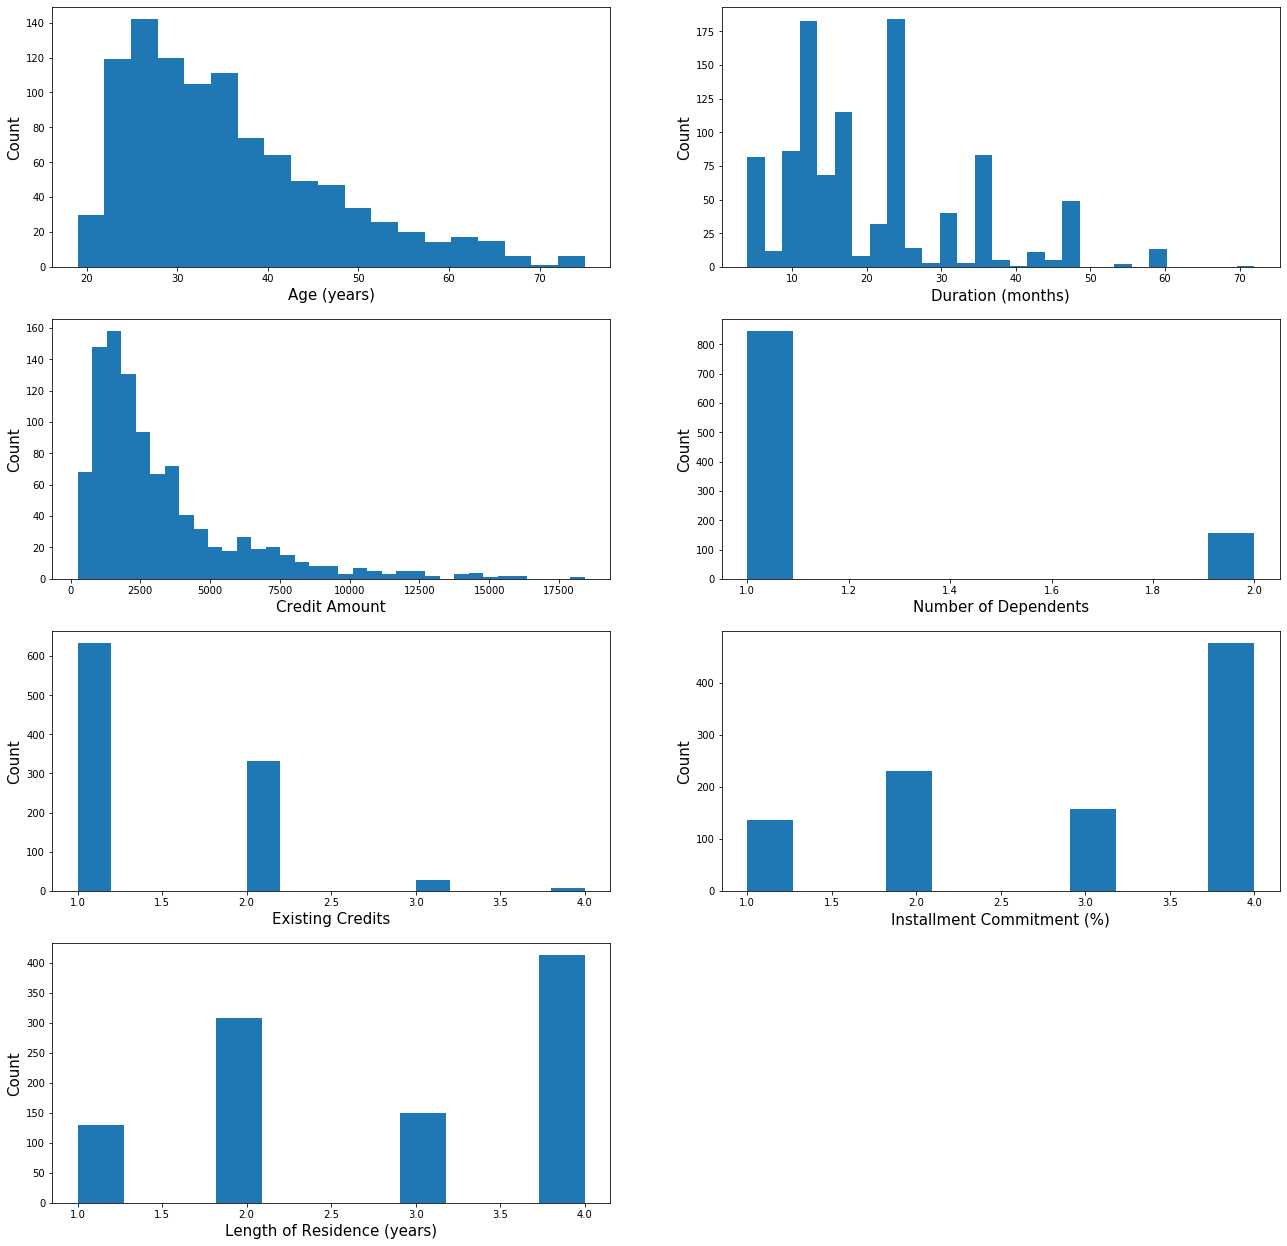

In [5]:
# Distribution of continuous variables
fig, ax = plt.subplots(4, 2, figsize=(22,22))
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = ax.ravel()
ax1.hist(df.data['age'], bins='auto')
ax1.set_ylabel('Count', fontsize=15)
ax1.set_xlabel('Age (years)', fontsize=15)

ax2.hist(df.data['duration'], bins='auto')
ax2.set_ylabel('Count', fontsize=15)
ax2.set_xlabel('Duration (months)', fontsize=15)

ax3.hist(df.data['credit_amount'], bins='auto')
ax3.set_ylabel('Count', fontsize=15)
ax3.set_xlabel('Credit Amount', fontsize=15)

ax4.hist(df.data['num_dependents'], bins='auto')
ax4.set_ylabel('Count', fontsize=15)
ax4.set_xlabel('Number of Dependents', fontsize=15)

ax5.hist(df.data['existing_credits'], bins='auto')
ax5.set_ylabel('Count', fontsize=15)
ax5.set_xlabel('Existing Credits', fontsize=15)

ax6.hist(df.data['installment_commitment'], bins='auto')
ax6.set_ylabel('Count', fontsize=15)
ax6.set_xlabel('Installment Commitment (%)', fontsize=15)

ax7.hist(df.data['residence_since'], bins='auto')
ax7.set_ylabel('Count', fontsize=15)
ax7.set_xlabel('Length of Residence (years)', fontsize=15)

fig.delaxes(ax8)
plt.show()

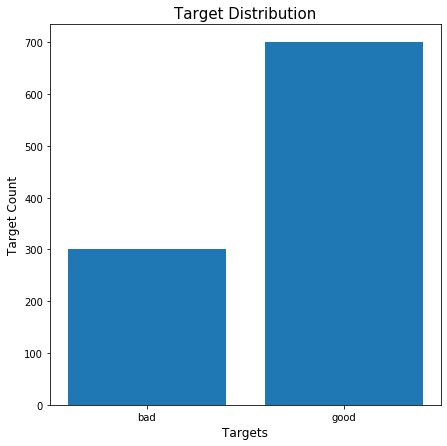

In [6]:
# Distribution of the target
target_names, target_nums = np.unique(target, return_counts=True)
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.bar(target_names, target_nums)
ax.set_xlabel('Targets', fontsize=12)
ax.set_ylabel('Target Count', fontsize=12)
ax.set_title('Target Distribution', fontsize=15)
plt.show()

##  1.3 
Split data into training and test set. Do not use the test set until a final evaluation in 1.5. Preprocess the data (such as treatment of categorical variables) without using a pipeline and evaluate an initial LogisticRegression model with an training/validation split.

In [7]:
# Preprocessing: label encode target class
label_encoder = preprocessing.LabelEncoder()
encoded_target = label_encoder.fit_transform(target)

One-hot encode categorical variables

In [8]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df.data, encoded_target, stratify=encoded_target, shuffle=True, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, shuffle=True, random_state=0)

In [9]:
X_train_ohe = pd.get_dummies(X_train, columns=categorical_total)
X_val_ohe = pd.get_dummies(X_val, columns=categorical_total) 

Fit model on training data and score on validation

In [10]:
logis = LogisticRegression().fit(X_train_ohe, y_train)
logis.score(X_val_ohe, y_val)

0.7606382978723404

## 1.4 
Use ColumnTransformer and pipeline to encode categorical variables (your choice of
OneHotEncoder or another one from the categorical_encoder package, or both). Evaluate
Logistic Regression, linear support vector machines and nearest neighbors using
cross-validation. How different are the results? How does scaling the continuous features with
StandardScaler influence the results?

In [11]:
preprocess = make_column_transformer((preprocessing.OneHotEncoder(), categorical_total))
cv_original = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [12]:
logis_pipe = make_pipeline(preprocess, LogisticRegression())
logis_scores = cross_val_score(logis_pipe, X_train_val, y_train_val, cv=cv_original)
np.mean(logis_scores)

0.74

In [13]:
svm_pipe = make_pipeline(preprocess, LinearSVC())
svm_scores = cross_val_score(svm_pipe, X_train_val, y_train_val, cv=cv_original)
np.mean(svm_scores)

0.7413333333333334

In [14]:
nn_pipe = make_pipeline(preprocess, KNeighborsClassifier())
nn_scores = cross_val_score(nn_pipe, X_train_val, y_train_val, cv=cv_original)
np.mean(nn_scores)

0.6986666666666667

Add in standard scalar

In [15]:
preprocess_with_ss = make_column_transformer((preprocessing.OneHotEncoder(), categorical_total), 
                                             (preprocessing.StandardScaler(), continuous))

In [16]:
logis_pipe = make_pipeline(preprocess_with_ss, LogisticRegression())
logis_scores = cross_val_score(logis_pipe, X_train_val, y_train_val, cv=cv_original)
np.mean(logis_scores)

0.748

In [17]:
svm_pipe = make_pipeline(preprocess_with_ss, LinearSVC())
svm_scores = cross_val_score(svm_pipe, X_train_val, y_train_val, cv=cv_original)
np.mean(svm_scores)

0.7546666666666667

In [18]:
nn_pipe = make_pipeline(preprocess_with_ss, KNeighborsClassifier())
nn_scores = cross_val_score(nn_pipe, X_train_val, y_train_val, cv=cv_original)
np.mean(nn_scores)

0.7346666666666667

When using logistic regression, linear SVM and nearest neighbors withotu scaling, the results are fairly similar as all three produce average cross validation accuracy scores ranging from 69%-74% accuracy. However, KNN performs the poorest of the three with logistic regression and linear SVM producing closer accuracy values which are higher. After adding in the standard scaler to scale the continuous data, all three models improve in their mean cross validation score, shifting the score range to 72%-75%. With this improvement, KNN is once against the poorest of the three models, producing the lowest accuracy score while linear SVM and logistic regression both have higher score values which are closer together.

# 1.5 
Tune the parameters using GridSearchCV. Do the results improve? Evaluate only the best
model on the test set. Visualize the performance as function of the parameters for all three models.

In [19]:
preprocess_with_ss = make_column_transformer((preprocessing.OneHotEncoder(), categorical_total), 
                                            (preprocessing.StandardScaler(), continuous))
cv_type = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [20]:
logis_pipe = make_pipeline(preprocess_with_ss, LogisticRegression())
param_grid = {'logisticregression__C': range(1, 25)}
lr_grid = GridSearchCV(logis_pipe, param_grid, cv=cv_type, n_jobs=-1, return_train_score=True)
lr_grid.fit(X_train_val, y_train_val)
lr_grid.best_score_

0.7533333333333333

In [21]:
svm_pipe = make_pipeline(preprocess_with_ss, LinearSVC())
param_grid = {'linearsvc__C': range(1, 25)}
svc_grid = GridSearchCV(svm_pipe, param_grid, cv=cv_type, n_jobs=-1, return_train_score=True)
svc_grid.fit(X_train_val, y_train_val)
svc_grid.best_score_

0.7586666666666667

In [22]:
nn_pipe = make_pipeline(preprocess_with_ss, KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 25)}
nn_grid = GridSearchCV(nn_pipe, param_grid, cv=cv_type, n_jobs=-1, return_train_score=True)
nn_grid.fit(X_train_val, y_train_val)
nn_grid.best_score_

0.7373333333333334

In [23]:
print(lr_grid.best_params_)
print(svc_grid.best_params_)
print(nn_grid.best_params_)

{'logisticregression__C': 5}
{'linearsvc__C': 7}
{'kneighborsclassifier__n_neighbors': 12}


Do the results improve?

By applying GridSearch, a slight improvement is seen by all three models as in comparison to 1.4, all three models show slightly higher cross validation accuracy scores when their parameters are tuned.

Evaluate the best model

In [24]:
svc_grid.fit(X_train_val, y_train_val)
svc_grid.score(X_test, y_test)

0.76

Visualize performance as a function of the parameters

In [25]:
lr_df = pd.DataFrame(lr_grid.cv_results_)
lr_mean_test_score = lr_df['mean_test_score']
lr_mean_train_score = lr_df['mean_train_score']
lr_c_param = lr_df['param_logisticregression__C']

svm_df = pd.DataFrame(svc_grid.cv_results_)
svm_mean_test_score = svm_df['mean_test_score']
svm_mean_train_score = svm_df['mean_train_score']
svm_c_param = svm_df['param_linearsvc__C']

nn_df = pd.DataFrame(nn_grid.cv_results_)
nn_mean_test_score = nn_df['mean_test_score']
nn_mean_train_score = nn_df['mean_train_score']
nn_n_param = nn_df['param_kneighborsclassifier__n_neighbors']

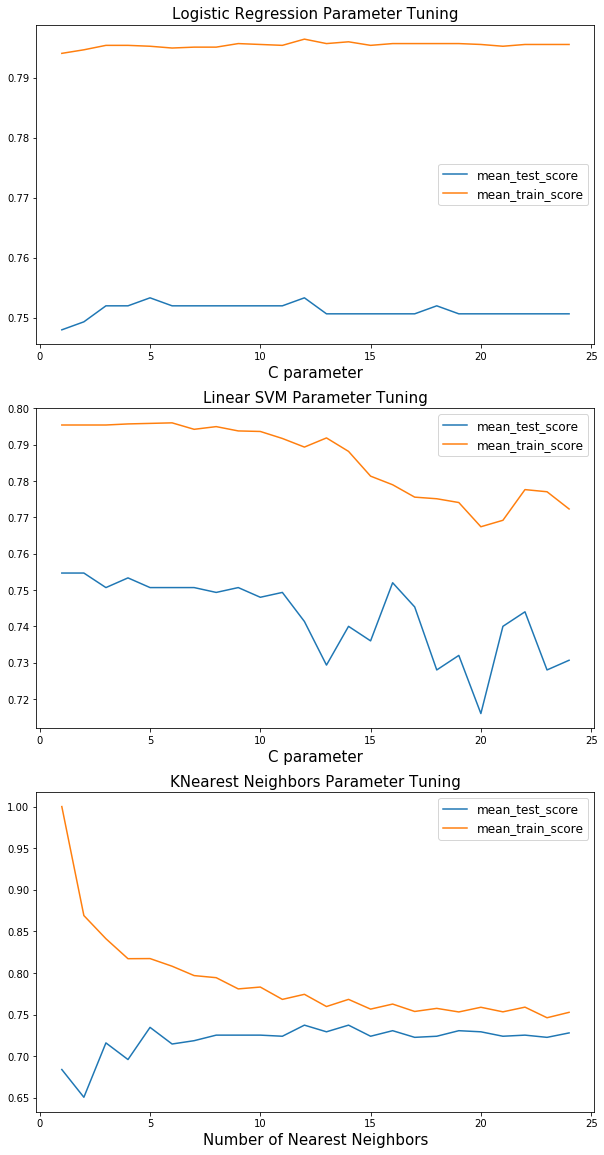

In [26]:
fig, ax = plt.subplots(3, 1, figsize=(10, 20))
ax1, ax2, ax3 = ax.ravel()

ax1.plot(lr_c_param, lr_mean_test_score)
ax1.plot(lr_c_param, lr_mean_train_score)
ax1.legend(['mean_test_score', 'mean_train_score'], fontsize=12)
ax1.set_xlabel('C parameter', fontsize=15)
ax1.set_title('Logistic Regression Parameter Tuning', fontsize=15)

ax2.plot(svm_c_param, svm_mean_test_score)
ax2.plot(svm_c_param, svm_mean_train_score)
ax2.legend(['mean_test_score', 'mean_train_score'], fontsize=12)
ax2.set_xlabel('C parameter', fontsize=15)
ax2.set_title('Linear SVM Parameter Tuning', fontsize=15)

ax3.plot(nn_n_param, nn_mean_test_score)
ax3.plot(nn_n_param, nn_mean_train_score)
ax3.legend(['mean_test_score', 'mean_train_score'],fontsize=12)
ax3.set_xlabel('Number of Nearest Neighbors', fontsize=15)
ax3.set_title('KNearest Neighbors Parameter Tuning', fontsize=15)

plt.show()

## 1.6 
Change the cross-validation strategy from ‘stratified k-fold’ to ‘kfold’ with shuffling. Do the
parameters that are found change? Do they change if you change the random seed of the
shuffling? Or if you change the random state of the split into training and test data?

In [27]:
cv_type_kfold = KFold(n_splits=10, shuffle=True, random_state=0)
preprocess_with_ss = make_column_transformer((preprocessing.OneHotEncoder(), categorical_total), 
                                             (preprocessing.StandardScaler(), continuous))

In [28]:
logis_pipe = make_pipeline(preprocess_with_ss, LogisticRegression())
param_grid = {'logisticregression__C': range(1, 25)}
lr_grid = GridSearchCV(logis_pipe, param_grid, cv=cv_type_kfold, n_jobs=-1, return_train_score=True)
lr_grid.fit(X_train_val, y_train_val)
lr_grid.best_score_

0.748

In [29]:
svm_pipe = make_pipeline(preprocess_with_ss, LinearSVC())
param_grid = {'linearsvc__C': range(1, 25)}
svc_grid = GridSearchCV(svm_pipe, param_grid, cv=cv_type_kfold, n_jobs=-1, return_train_score=True)
svc_grid.fit(X_train_val, y_train_val)
svc_grid.best_score_

0.752

In [30]:
nn_pipe = make_pipeline(preprocess_with_ss, KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 25)}
nn_grid = GridSearchCV(nn_pipe, param_grid, cv=cv_type_kfold, n_jobs=-1, return_train_score=True)
nn_grid.fit(X_train_val, y_train_val)
nn_grid.best_score_

0.7333333333333334

In [31]:
print(lr_grid.best_params_)
print(svc_grid.best_params_)
print(nn_grid.best_params_)

{'logisticregression__C': 2}
{'linearsvc__C': 13}
{'kneighborsclassifier__n_neighbors': 16}


Change the random state of the shuffling

In [32]:
cv_type_kfold = KFold(n_splits=10, shuffle=True, random_state=5)
preprocess_with_ss = make_column_transformer((preprocessing.OneHotEncoder(), categorical_total), 
                                             (preprocessing.StandardScaler(), continuous))

In [33]:
logis_pipe = make_pipeline(preprocess_with_ss, LogisticRegression())
param_grid = {'logisticregression__C': range(1, 25)}
lr_grid = GridSearchCV(logis_pipe, param_grid, cv=cv_type_kfold, n_jobs=-1, return_train_score=True)
lr_grid.fit(X_train_val, y_train_val)
lr_grid.best_score_

0.7546666666666668

In [43]:
svm_pipe = make_pipeline(preprocess_with_ss, LinearSVC())
param_grid = {'linearsvc__C': range(1, 25)}
svc_grid = GridSearchCV(svm_pipe, param_grid, cv=cv_type_kfold, n_jobs=-1, return_train_score=True)
svc_grid.fit(X_train_val, y_train_val)
svc_grid.best_score_

0.7626666666666667

In [35]:
nn_pipe = make_pipeline(preprocess_with_ss, KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 25)}
nn_grid = GridSearchCV(nn_pipe, param_grid, cv=cv_type_kfold, n_jobs=-1, return_train_score=True)
nn_grid.fit(X_train_val, y_train_val)
nn_grid.best_score_

0.736

In [44]:
print(lr_grid.best_params_)
print(svc_grid.best_params_)
print(nn_grid.best_params_)

{'logisticregression__C': 1}
{'linearsvc__C': 12}
{'kneighborsclassifier__n_neighbors': 3}


Changing random state of the split for training and testing

In [37]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df.data, encoded_target, stratify=encoded_target, shuffle=True, random_state=5)

In [38]:
cv_type_kfold = KFold(n_splits=10, shuffle=True, random_state=5)
preprocess_with_ss = make_column_transformer((preprocessing.OneHotEncoder(), categorical_total), 
                                             (preprocessing.StandardScaler(), continuous))

In [39]:
logis_pipe = make_pipeline(preprocess_with_ss, LogisticRegression())
param_grid = {'logisticregression__C': range(1, 25)}
lr_grid = GridSearchCV(logis_pipe, param_grid, cv=cv_type_kfold, n_jobs=-1, return_train_score=True)
lr_grid.fit(X_train_val, y_train_val)
lr_grid.best_score_

0.7586666666666668

In [40]:
svm_pipe = make_pipeline(preprocess_with_ss, LinearSVC())
param_grid = {'linearsvc__C': range(1, 25)}
svc_grid = GridSearchCV(svm_pipe, param_grid, cv=cv_type_kfold, n_jobs=-1, return_train_score=True)
svc_grid.fit(X_train_val, y_train_val)
svc_grid.best_score_

0.7546666666666667

In [41]:
nn_pipe = make_pipeline(preprocess_with_ss, KNeighborsClassifier())
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 25)}
nn_grid = GridSearchCV(nn_pipe, param_grid, cv=cv_type_kfold, n_jobs=-1, return_train_score=True)
nn_grid.fit(X_train_val, y_train_val)
nn_grid.best_score_

0.7466666666666667

In [42]:
print(lr_grid.best_params_)
print(svc_grid.best_params_)
print(nn_grid.best_params_)

{'logisticregression__C': 1}
{'linearsvc__C': 6}
{'kneighborsclassifier__n_neighbors': 3}


By changing the cross-validation strategy from Stratified KFold to KFold, the C parameter changes for both logistic regression and linear SVM as does the number of neighbors for KNN. The parameters once again change when random seed of the shuffling is changed and when the random state of the train/test split is changed, the C parameter for logistic regression changes however, the other two remain the same.

## 1.7 
Visualize the 20 most important coefficients for LogisticRegression and Linear Support
Vector Machines using hyper-parameters that performed well in the grid-search.

In [48]:
# Best performance when C = 1 for logistic regression
best_lr_pipe = make_pipeline(preprocess_with_ss, LogisticRegression(C=1))
best_lr_pipe.fit(X_train_val, y_train_val)
# Best performance when C = 12 for svc
best_svc_pipe = make_pipeline(preprocess_with_ss, LinearSVC(C=12))
best_svc_pipe.fit(X_train_val, y_train_val)

# Get the coefficients
best_lr_coeff = best_lr_pipe['logisticregression'].coef_[0]
best_svc_coeff = best_svc_pipe['linearsvc'].coef_[0]

In [49]:
# Get the top 20 coefficients with the greatest absolute value
svc_coeff_abs = [abs(x) for x in best_svc_coeff]
svc_coeff_abs.sort(reverse=True)
top_20_svc = svc_coeff_abs[0:21]

lr_coeff_abs = [abs(x) for x in best_lr_coeff]
lr_coeff_abs.sort(reverse=True)
top_20_lr = lr_coeff_abs[0:21]

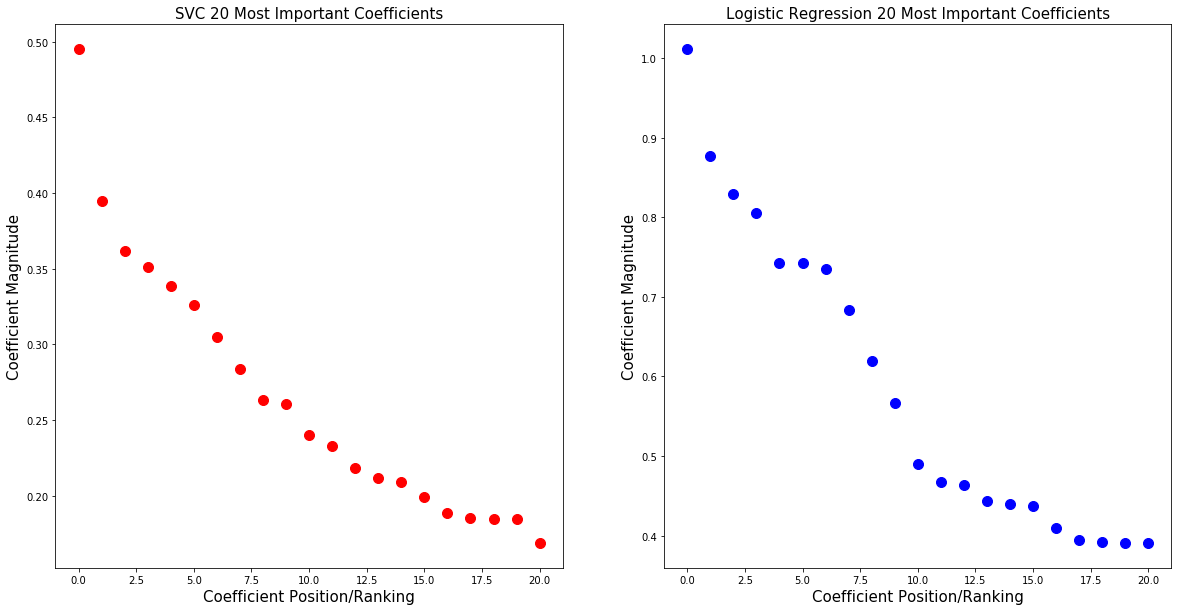

In [50]:
# Visualize the performance
fig, ax = plt.subplots(1,2, figsize=(20,10))
ax1, ax2 = ax.ravel()
ax1.plot(range(0,21), top_20_svc, 'ro', markersize='10')
ax1.set_xlabel('Coefficient Position/Ranking',fontsize=15)
ax1.set_ylabel('Coefficient Magnitude',fontsize=15)
ax1.set_title('SVC 20 Most Important Coefficients',fontsize=15)
ax2.plot(range(0,21), top_20_lr, 'bo', markersize='10')
ax2.set_xlabel('Coefficient Position/Ranking', fontsize=15)
ax2.set_ylabel('Coefficient Magnitude', fontsize=15)
ax2.set_title('Logistic Regression 20 Most Important Coefficients', fontsize=15)
plt.show()